# Import Libraries

In [88]:
import pandas as pd
pd.set_option('display.max_columns',None)
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Download necessary libraries

In [5]:
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('vader_lexicon')

## Read Data

In [6]:
train_df = pd.read_csv("../data/Twitter/twitter_training.csv",header=None)
test_df = pd.read_csv("../data/Twitter/twitter_validation.csv",header=None)
train_df.columns = ['number','topic','sentiment','tweet']
test_df.columns = ['number','topic','sentiment','tweet']

In [7]:
train_df.head()

,number,topic,sentiment,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [8]:
test_df.head()

,number,topic,sentiment,tweet
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


## Short Data Summary

In [9]:
train_df.shape, test_df.shape

((74682, 4), (1000, 4))

In [10]:
train_df.sentiment.unique(), test_df.sentiment.unique()

(array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object),
 array(['Irrelevant', 'Neutral', 'Negative', 'Positive'], dtype=object))

In [11]:
train_df.groupby("sentiment").count()

,number,topic,tweet
sentiment,,,
Irrelevant,12990,12990,12875
Negative,22542,22542,22358
Neutral,18318,18318,18108
Positive,20832,20832,20655


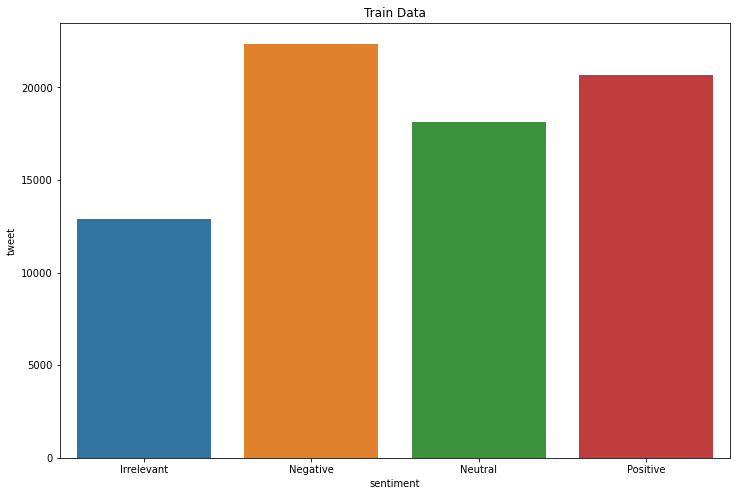

In [12]:
fig,ax = plt.subplots(figsize=(12,8))
sns.barplot(data=train_df.groupby('sentiment').count().reset_index(), x='sentiment', y='tweet',ax = ax)
plt.title("Train Data")
plt.show()
plt.close()

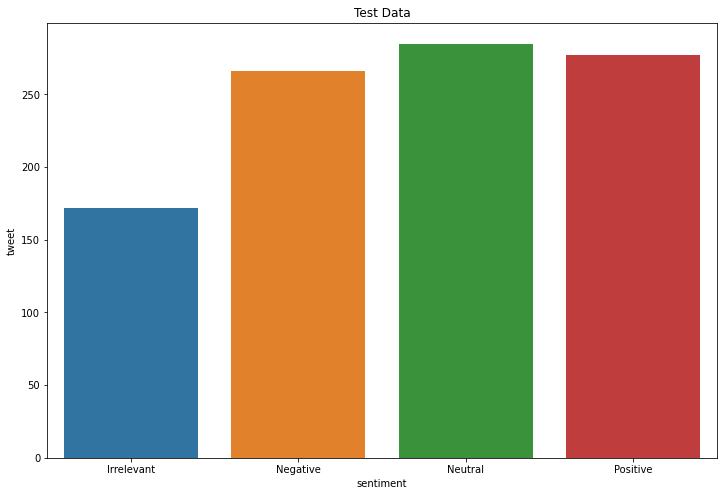

In [13]:
fig,ax = plt.subplots(figsize=(12,8))
sns.barplot(data=test_df.groupby('sentiment').count().reset_index(), x='sentiment', y='tweet',ax = ax)
plt.title("Test Data")
plt.show()
plt.close()

### Data Preprocessing - encode sentiment // keep only sentiment &tweet

In [14]:
train_df.head()

,number,topic,sentiment,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [15]:
test_df.head()

,number,topic,sentiment,tweet
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [16]:
train_df.groupby('sentiment').count()

,number,topic,tweet
sentiment,,,
Irrelevant,12990,12990,12875
Negative,22542,22542,22358
Neutral,18318,18318,18108
Positive,20832,20832,20655


In [17]:
test_df.groupby('sentiment').count()

,number,topic,tweet
sentiment,,,
Irrelevant,172,172,172
Negative,266,266,266
Neutral,285,285,285
Positive,277,277,277


Delete Irrelevant tweets and encode sentiment into numerical. 

In [18]:
def process_sentiment(df):
    df = df[df['sentiment'].isin(['Positive','Negative','Neutral'])]
    df.loc[df.sentiment=='Positive', 'sentiment'] = 2
    df.loc[df.sentiment=='Neutral', 'sentiment'] = 1
    df.loc[df.sentiment=='Negative', 'sentiment'] = 0
    df['sentiment'] = df['sentiment'].astype(int)
    #df.drop(['number','topic'],axis=1,inplace=True)
    return df[['tweet','sentiment']]

In [19]:
train_df = process_sentiment(train_df)
test_df = process_sentiment(test_df)

/Users/dannykang/opt/anaconda3/envs/webscrap/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/var/folders/f7/frkz7fzd1hd5r3hc24670dnm0000gn/T/ipykernel_82194/3760496259.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['sentiment'].astype(int)


In [20]:
train_df['sentiment'].unique(), test_df['sentiment'].unique()

(array([2, 1, 0]), array([1, 0, 2]))

# Tweet Processing

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61692 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      61121 non-null  object
 1   sentiment  61692 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ MB


In [22]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828 entries, 1 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      828 non-null    object
 1   sentiment  828 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 19.4+ KB


The dtype of the tweet column is object so there might be some Nan values which we'll have to get rid of

In [23]:
train_df.isnull().sum(), test_df.isnull().sum()

(tweet        571
 sentiment      0
 dtype: int64,
 tweet        0
 sentiment    0
 dtype: int64)

In [24]:
train_df.shape, test_df.shape

((61692, 2), (828, 2))

In [25]:
train_df = train_df[train_df.tweet.notnull()]
test_df = test_df[test_df.tweet.notnull()]
train_df['tweet'] = train_df['tweet'].astype(str)
test_df['tweet'] = test_df['tweet'].astype(str)

In [26]:
train_df.shape, test_df.shape

((61121, 2), (828, 2))

In [27]:
train_df.isnull().sum(), test_df.isnull().sum()

(tweet        0
 sentiment    0
 dtype: int64,
 tweet        0
 sentiment    0
 dtype: int64)

In [28]:
from tensorflow.keras.utils import to_categorical

target = train_df.sentiment.values
y_target = to_categorical(target)
y_test = test_df['sentiment'].values

# number of numerical values exist in y_target's column
num_classes = y_target.shape[1]

In [29]:
print(num_classes)

3


# Train Test Split

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_df['tweet'],
                                                  y_target,
                                                  test_size = 0.2,
                                                  stratify = train_df['sentiment'])

In [31]:
X_test = test_df['tweet']

# Model Parameters

In [32]:
num_epochs = 15
# Max length of tokens
max_token_length = 45
batch_size = 64

In [33]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dropout,Dense
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

# Bert Base Uncased

In [122]:
from transformers import TFBertModel,  BertConfig, BertTokenizerFast, AutoTokenizer

In [123]:
#name of pretrained model
model_name = 'bert-base-uncased'  

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Transformers BERT model
transformer_bert_model = TFBertModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [124]:
# Load the MainLayer
bert = transformer_bert_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_token_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers BERT model as a layer in a Keras model
model_bert = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(model_bert, training=False)

# Then build your model output
Sentiments = Dense(units=3, kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Sentiment')(pooled_output)
outputs = {'Sentiment': Sentiments}

# And combine it all in a model object
model_bert = Model(inputs=inputs, outputs=outputs, name='BERT_MultiClass')

In [125]:
model_bert.summary()

Model: "BERT_MultiClass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 45)]              0         
                                                                 
 bert (TFBertMainLayer)      TFBaseModelOutputWithPoo  109482240 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             45, 768),                           
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                   

In [126]:
x_train = tokenizer(
            text=X_train.tolist(),
            max_length=max_token_length,
            truncation=True,
            add_special_tokens=True,
            padding='max_length', 
            return_token_type_ids = False,
            return_attention_mask = True,
            return_tensors='tf')
x_val = tokenizer(
            text=X_val.tolist(),
            max_length=max_token_length,
            truncation=True,
            add_special_tokens=True,
            padding='max_length', 
            return_token_type_ids = False,
            return_attention_mask = True,
            return_tensors='tf')
x_test = tokenizer(
            text=X_test.tolist(),
            max_length=max_token_length,
            truncation=True,
            add_special_tokens=True,
            padding='max_length', 
            return_token_type_ids = False,
            return_attention_mask = True,
            return_tensors='tf')

In [127]:
# freeze the BERT layer
model_bert.layers[2].trainable = False

# compile the model
optimizer = Adam(learning_rate = 5e-05, epsilon = 1e-08,decay=0.01)
loss = CategoricalCrossentropy(from_logits=True)
acc = CategoricalAccuracy('accuracy')

In [128]:
model_bert.summary()

Model: "BERT_MultiClass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 45)]              0         
                                                                 
 bert (TFBertMainLayer)      TFBaseModelOutputWithPoo  109482240 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             45, 768),                           
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                   

In [129]:
model_bert.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [130]:
model_bert

In [131]:
# Fit the model
history_bert = model_bert.fit(
    x={'input_ids': x_train['input_ids']},
    y={'Sentiment': y_train},
    validation_data=({'input_ids': x_val['input_ids']},{'Sentiment': y_val}),
    batch_size=batch_size,
    epochs=num_epochs)


Epoch 1/15
764/764 [==============================] - 6333s 8s/step - loss: 0.6627 - accuracy: 0.7221 - val_loss: 0.5258 - val_accuracy: 0.7904
Epoch 2/15
764/764 [==============================] - 6120s 8s/step - loss: 0.4392 - accuracy: 0.8311 - val_loss: 0.4413 - val_accuracy: 0.8281
Epoch 3/15
764/764 [==============================] - 6856s 9s/step - loss: 0.3432 - accuracy: 0.8713 - val_loss: 0.3922 - val_accuracy: 0.8541
Epoch 4/15
764/764 [==============================] - 7154s 9s/step - loss: 0.2880 - accuracy: 0.8943 - val_loss: 0.3660 - val_accuracy: 0.8654
Epoch 5/15
764/764 [==============================] - 6919s 9s/step - loss: 0.2525 - accuracy: 0.9070 - val_loss: 0.3542 - val_accuracy: 0.8718
Epoch 6/15
764/764 [==============================] - 6832s 9s/step - loss: 0.2268 - accuracy: 0.9173 - val_loss: 0.3380 - val_accuracy: 0.8785
Epoch 7/15
764/764 [==============================] - 6646s 9s/step - loss: 0.2099 - accuracy: 0.9229 - val_loss: 0.3329 - val_accuracy:

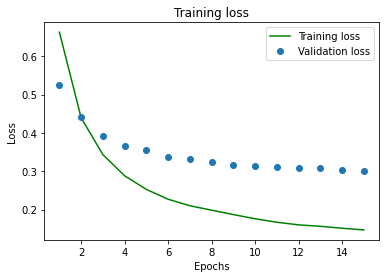

In [132]:
loss_train = history_bert.history['loss']
loss_valid = history_bert.history['val_loss']
epochs = range(1,num_epochs+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_valid, 'o', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

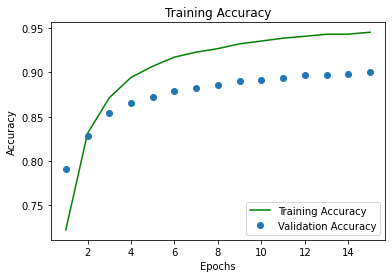

In [133]:
accuracy_train = history_bert.history['accuracy']
accuracy_valid = history_bert.history['val_accuracy']
epochs = range(1,num_epochs+1)
plt.plot(epochs, accuracy_train, 'g', label='Training Accuracy')
plt.plot(epochs, accuracy_valid, 'o', label='Validation Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [134]:
bert_model_eval = model_bert.evaluate(
    x={'input_ids': x_val['input_ids']},
    y={'Sentiment': y_val}
)

383/383 [==============================] - 606s 2s/step - loss: 0.3018 - accuracy: 0.9007


In [135]:
y_val_predicted_bert = model_bert.predict(
    x={'input_ids': x_val['input_ids']},
)

383/383 [==============================] - 823s 2s/step


In [136]:
label_predicted_bert = model_bert.predict(
    x={'input_ids': x_test['input_ids']},
)

26/26 [==============================] - 48s 2s/step


In [137]:
label_pred_bert=[np.argmax(i) for i in label_predicted_bert['Sentiment']]

# albert base v2

In [35]:
from transformers import TFAlbertModel,  AlbertConfig, AlbertTokenizerFast

In [36]:
# Name of the BERT model to use
model_name = 'albert-base-v2'

# Load transformers config and set output_hidden_states to False
config = AlbertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load BERT tokenizer
#tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer = AlbertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Transformers BERT model
transformer_albert_model = TFAlbertModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at albert-base-v2 were not used when initializing TFAlbertModel: ['predictions']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertModel were initialized from the model checkpoint at albert-base-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


In [37]:
x_train = tokenizer(
            text=X_train.tolist(),
            max_length=max_token_length,
            truncation=True,
            add_special_tokens=True,
            padding='max_length', 
            return_token_type_ids = False,
            return_attention_mask = True,
            return_tensors='tf')
x_val = tokenizer(
            text=X_val.tolist(),
            max_length=max_token_length,
            truncation=True,
            add_special_tokens=True,
            padding='max_length', 
            return_token_type_ids = False,
            return_attention_mask = True,
            return_tensors='tf')
x_test = tokenizer(
            text=X_test.tolist(),
            max_length=max_token_length,
            truncation=True,
            add_special_tokens=True,
            padding='max_length', 
            return_token_type_ids = False,
            return_attention_mask = True,
            return_tensors='tf')

In [38]:
# Load the MainLayer
albert = transformer_albert_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_token_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers BERT model as a layer in a Keras model
model_albert = albert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(model_albert, training=False)

# Then build your model output
Sentiments = Dense(units=3, kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Sentiment')(pooled_output)
outputs = {'Sentiment': Sentiments}

# And combine it all in a model object
model_albert = Model(inputs=inputs, outputs=outputs, name='ALBERT_MultiClass')

In [39]:
model_albert.summary()

Model: "ALBERT_MultiClass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 45)]              0         
                                                                 
 albert (TFAlbertMainLayer)  TFBaseModelOutputWithPoo  11683584  
                             ling(last_hidden_state=(            
                             None, 45, 768),                     
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 pooled_output (Dropout)     (None, 768)               0         
                                                                 
 Sentiment (Dense)           (None, 3)           

In [40]:
# freeze the BERT layer
#model_bert.layers[2].trainable = False

# compile the model
optimizer = Adam(learning_rate = 5e-05, epsilon = 1e-08,decay=0.01)
loss = CategoricalCrossentropy(from_logits=True)
acc = CategoricalAccuracy('accuracy')

In [41]:
model_albert.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [42]:
model_albert

In [43]:
# Fit the model
history_albert = model_albert.fit(
    x={'input_ids': x_train['input_ids']},
    y={'Sentiment': y_train},
    validation_data=({'input_ids': x_val['input_ids']},{'Sentiment': y_val}),
    batch_size=batch_size,
    epochs=num_epochs)


Epoch 1/15
764/764 [==============================] - 7122s 9s/step - loss: 0.9202 - accuracy: 0.5440 - val_loss: 0.7156 - val_accuracy: 0.7040
Epoch 2/15
764/764 [==============================] - 7426s 10s/step - loss: 0.6060 - accuracy: 0.7582 - val_loss: 0.5817 - val_accuracy: 0.7706
Epoch 3/15
764/764 [==============================] - 6242s 8s/step - loss: 0.4376 - accuracy: 0.8360 - val_loss: 0.5217 - val_accuracy: 0.7962
Epoch 4/15
764/764 [==============================] - 5558s 7s/step - loss: 0.3124 - accuracy: 0.8904 - val_loss: 0.5040 - val_accuracy: 0.8132
Epoch 5/15
764/764 [==============================] - 5491s 7s/step - loss: 0.2295 - accuracy: 0.9240 - val_loss: 0.5147 - val_accuracy: 0.8168
Epoch 6/15
764/764 [==============================] - 5462s 7s/step - loss: 0.1760 - accuracy: 0.9435 - val_loss: 0.5351 - val_accuracy: 0.8221
Epoch 7/15
764/764 [==============================] - 5446s 7s/step - loss: 0.1418 - accuracy: 0.9553 - val_loss: 0.5618 - val_accuracy

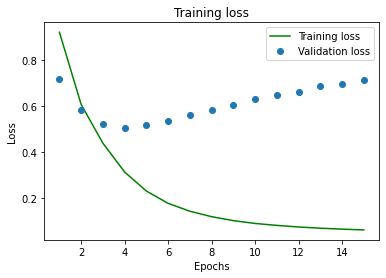

In [44]:
loss_train = history_albert.history['loss']
loss_valid = history_albert.history['val_loss']
epochs = range(1,num_epochs+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_valid, 'o', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

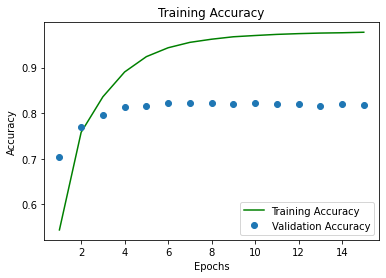

In [45]:
accuracy_train = history_albert.history['accuracy']
accuracy_valid = history_albert.history['val_accuracy']
epochs = range(1,num_epochs+1)
plt.plot(epochs, accuracy_train, 'g', label='Training Accuracy')
plt.plot(epochs, accuracy_valid, 'o', label='Validation Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [46]:
albet_model_eval = model_albert.evaluate(
    x={'input_ids': x_val['input_ids']},
    y={'Sentiment': y_val}
)

383/383 [==============================] - 517s 1s/step - loss: 0.7133 - accuracy: 0.8172


In [47]:
y_val_predicted_albert = model_albert.predict(
    x={'input_ids': x_val['input_ids']},
)

383/383 [==============================] - 515s 1s/step


In [48]:
label_predicted_albert = model_albert.predict(
    x={'input_ids': x_test['input_ids']},
)

26/26 [==============================] - 35s 1s/step


In [49]:
label_pred_albert=[np.argmax(i) for i in label_predicted_albert['Sentiment']]

# Roberta Base

In [50]:
from transformers import RobertaTokenizer, TFRobertaModel, RobertaConfig  

In [51]:
model_name = 'roberta-base'

In [52]:
# Load transformers config and set output_hidden_states to False
config = RobertaConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = RobertaTokenizer.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Transformers BERT model
transformer_roberta_model = TFRobertaModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [53]:
x_train = tokenizer(
          text=X_train.tolist(),
          add_special_tokens=True,
          max_length=max_token_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)
x_val = tokenizer(
          text=X_val.tolist(),
          add_special_tokens=True,
          max_length=max_token_length,
        truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)
x_test = tokenizer(
          text=X_test.tolist(),
          add_special_tokens=True,
          max_length=max_token_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)

In [54]:
# Load the MainLayer
roberta = transformer_roberta_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_token_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers BERT model as a layer in a Keras model
roberta_model = roberta(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(roberta_model, training=False)

# Then build your model output
Sentiments = Dense(units=3, kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Sentiment')(pooled_output)
outputs = {'Sentiment': Sentiments}

# And combine it all in a model object
model_roberta = Model(inputs=inputs, outputs=outputs, name=model_name)

In [55]:
model_roberta.summary()

Model: "roberta-base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 45)]              0         
                                                                 
 roberta (TFRobertaMainLayer  TFBaseModelOutputWithPoo  124645632
 )                           lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             45, 768),                           
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                      

In [56]:
# Set an optimizer
optimizer = Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)

# Set loss and metrics
loss = {'Sentiment': CategoricalCrossentropy(from_logits = True)}

# Compile the model
model_roberta.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

In [57]:
# Fit the model
history_roberta = model_roberta.fit(
    x={'input_ids': x_train['input_ids']},
    y={'Sentiment': y_train},
    validation_data=({'input_ids': x_val['input_ids']},{'Sentiment': y_val}),
    batch_size=batch_size,
    epochs=num_epochs,
    verbose=1)
#model_bert.save('MODEL-BERT.h5')

Epoch 1/15
764/764 [==============================] - 5653s 7s/step - loss: 0.6750 - accuracy: 0.7119 - val_loss: 0.5522 - val_accuracy: 0.7713
Epoch 2/15
764/764 [==============================] - 5660s 7s/step - loss: 0.4975 - accuracy: 0.8002 - val_loss: 0.4785 - val_accuracy: 0.8115
Epoch 3/15
764/764 [==============================] - 5672s 7s/step - loss: 0.4181 - accuracy: 0.8342 - val_loss: 0.4396 - val_accuracy: 0.8328
Epoch 4/15
764/764 [==============================] - 5642s 7s/step - loss: 0.3695 - accuracy: 0.8561 - val_loss: 0.4072 - val_accuracy: 0.8452
Epoch 5/15
764/764 [==============================] - 5688s 7s/step - loss: 0.3365 - accuracy: 0.8702 - val_loss: 0.3921 - val_accuracy: 0.8533
Epoch 6/15
764/764 [==============================] - 7334s 10s/step - loss: 0.3078 - accuracy: 0.8807 - val_loss: 0.3800 - val_accuracy: 0.8564
Epoch 7/15
764/764 [==============================] - 8050s 11s/step - loss: 0.2880 - accuracy: 0.8891 - val_loss: 0.3730 - val_accurac

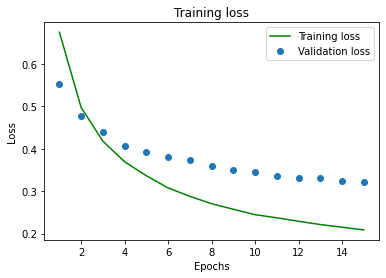

In [58]:
loss_train = history_roberta.history['loss']
loss_valid = history_roberta.history['val_loss']
epochs = range(1,num_epochs+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_valid, 'o', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

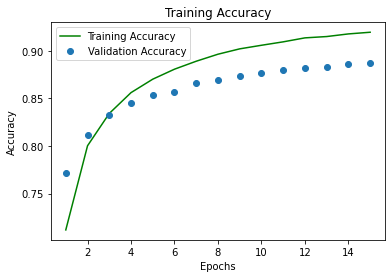

In [59]:
accuracy_train = history_roberta.history['accuracy']
accuracy_valid = history_roberta.history['val_accuracy']
epochs = range(1,num_epochs+1)
plt.plot(epochs, accuracy_train, 'g', label='Training Accuracy')
plt.plot(epochs, accuracy_valid, 'o', label='Validation Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [60]:
roberta_model_eval = model_roberta.evaluate(
    x={'input_ids': x_val['input_ids']},
    y={'Sentiment': y_val}
)

383/383 [==============================] - 564s 1s/step - loss: 0.3229 - accuracy: 0.8875


In [61]:
y_val_predicted_roberta = model_roberta.predict(
    x={'input_ids': x_val['input_ids']},
)

383/383 [==============================] - 595s 2s/step


In [62]:
label_predicted_roberta = model_roberta.predict(
    x={'input_ids': x_test['input_ids']},
)

26/26 [==============================] - 35s 1s/step


In [64]:
label_pred_roberta=[np.argmax(i) for i in label_predicted_roberta['Sentiment']]

# Model comparison

In [141]:
# accuracy score for each:
print("Accuracy Score BERT: {}".format(accuracy_score(y_test,label_pred_bert)))
print("Accuracy Score ALBERT: {}".format(accuracy_score(y_test,label_pred_albert)))
print("Accuracy Score ROBERTA: {}".format(accuracy_score(y_test,label_pred_roberta)))

Accuracy Score BERT: 0.9601449275362319
Accuracy Score ALBERT: 0.927536231884058
Accuracy Score ROBERTA: 0.9468599033816425


### Confusion Matrix

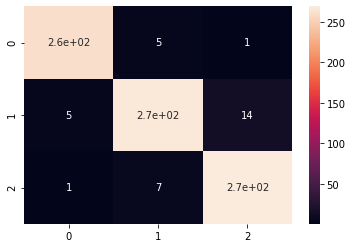

In [139]:
## Albert
fig,ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, label_pred_bert),annot=True,ax=ax)
plt.show()
plt.close()


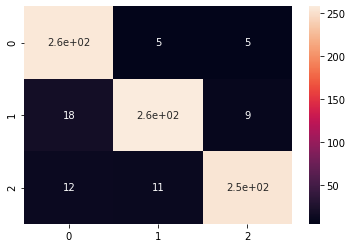

In [115]:
## Albert
fig,ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, label_pred_albert),annot=True,ax=ax)
plt.show()
plt.close()


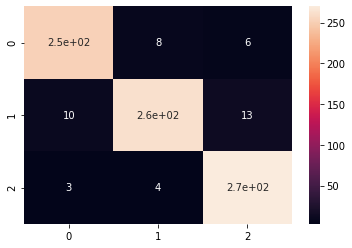

In [116]:
## Albert
fig,ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, label_pred_roberta),annot=True,ax=ax)
plt.show()
plt.close()


## PR Curve

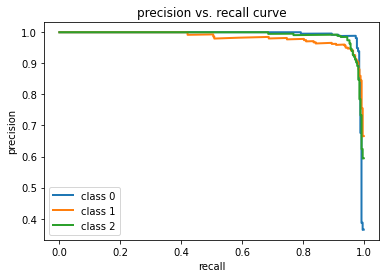

In [140]:
## PR Curve
precision = dict()
recall = dict()
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(pd.get_dummies(y_test).values[:, i],
                                                        label_predicted_bert['Sentiment'][:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

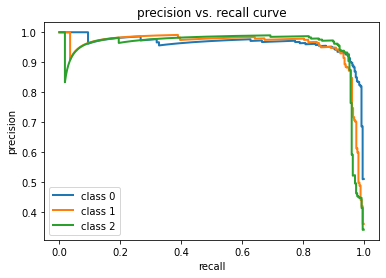

In [120]:
## PR Curve
precision = dict()
recall = dict()
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(pd.get_dummies(y_test).values[:, i],
                                                        label_predicted_albert['Sentiment'][:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

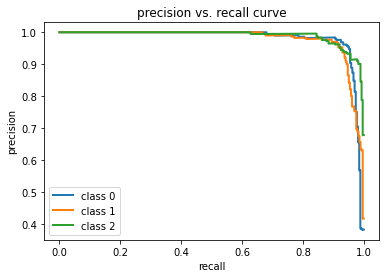

In [121]:
## PR Curve
precision = dict()
recall = dict()
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(pd.get_dummies(y_test).values[:, i],
                                                        label_predicted_roberta['Sentiment'][:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()